In [687]:
import json
import re
import os

In [688]:
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]



def evaluate_results(results_filepath, individual_results=False, ablation=False):
    data_final = []
    with open(results_filepath, 'r') as f:
        data = json.load(f)
    data_final += data

    individual_results_list = []

    i = 1
    p, r = 0, 0
    ac = 0
    for i, item in enumerate(data_final):
        pred = item['pred']
        res = ""
        correct=False

        # pattern = r": *([A-Z, ]+)\." # match the brick names between : and .
        # pattern = r"(?s): *([^:]*[A-Z, ]+)\." # match the brick names between : and .
        # pattern = r": *([A-Za-z, ]+)\."
        # pattern = r": *([A-Za-z, ]+)(\.|$)"
        # pattern2 = r"(?:[:.]) *([A-Za-z, ()*]+)(\.|$)"
        pattern = r': *([A-Z](?![a-z])(?:, *[A-Z](?![a-z]))*)'
        pattern2 = r'(?:[:.]) *([A-Z](?![a-z])(?:, *[A-Z](?![a-z]))*)'
        pattern3 = r'\b[A-Z]\b|(?<![A-Za-z])[A-Z](?![a-z])'

        match = re.search(pattern, item['pred'][-200:])
        if not match:
            match = re.search(pattern2, item['pred'][-200:])
        if not match:
            match = re.search(pattern3, item['pred'][-200:])
            
        if match:
            res = match.group(0)
            res = ''.join(list(filter(lambda x: x.isupper(), res)))
            if len(res)>=2:
                if res[0] == res[1]:
                    res = res[1:] # remove the first letter if it is repeated
            if item['label'][-1] != res[-1]: 
                res += item['label'][-1] # add the last letter of the label (target brick) if it is not already in the prediction
            if res == item['label']:
                # print('correct')
                correct = True
                ac += 1
            else:
                pass
                # print(item['pred'])
                # print(res)
                # print(item['label'])
                # print(f'{i} {item["label"]} \t {res} \t {match.group(0)}')
                # print([item['pred'][-200:]])
            lcs = longest_common_substring(res,item['label'] )
            len(lcs)/len(item['label'])
            len(lcs)/len(res)
            if len(res)==0:
                pass
            r += len(lcs)/len(item['label'])
            if len(res)==0:
                continue
            p += len(lcs)/len(res)
        else:
            # print(f'no answer found in {item["pred"][-200:]}')
            pass
        if individual_results:
            if ablation:
                individual_results_list.append({
                    'i': i,
                    'pred': res,
                    'truth': item['label'],
                    'correct': correct,
                    'gap': item['gap'],
                    'gap_type': item['gap_type']
                })
            else:
                individual_results_list.append({
                    'i': i,
                    'pred': res,
                    'truth': item['label'],
                    'correct': correct
                })

    evaluation = {
        'accuracy': ac/len(data_final),
        'precision': p/len(data_final),
        'recall': r/len(data_final)
    }
    if individual_results:
        return evaluation, individual_results_list
    else:
        return evaluation
    # acc = ac/len(data_final)
    # print('acc', acc)
    # print(p/len(data_final))
    # print(r/len(data_final))

In [689]:

# models = [
#     'gpt-3.5-turbo',
#     'gpt-4o-mini',
#     'gpt-4o-2024-08-06'
# ]

# for model_name in models:
#     examples_data_dir = '../data/brick_1D_50'
#     results_file_path = os.path.join(examples_data_dir, f'results_{model_name}.json')
#     print(model_name)
#     evaluate_results(results_filepath=results_file_path)

In [690]:
eval = []
individual_results_overall = []
results_dir = '../data/results'
# iterate over json files in the results directory
for file in os.listdir(results_dir):
    if file.endswith('.json'):
        results_file_path = os.path.join(results_dir, file)
        evaluation, individual_results = evaluate_results(results_filepath=results_file_path, individual_results=True)
        # add the model name to the evaluation
        evaluation['model'] = file.split('_')[-1].strip('.json')
        # add the dimension to the evaluation
        if '1D' in file:
            evaluation['dimension'] = '1D'
        elif '2D' in file:
            evaluation['dimension'] = '2D'
        else:
            evaluation['dimension'] = ''
        if 'gap' in file:
            evaluation['prompt_modality'] = 'topological'
        else:    
            evaluation['prompt_modality'] = 'metrical'
        # add the modality to the evaluation
        if 'text' in file or 'txt' in file:
            evaluation['modality'] = 'text'
            evaluation['prompt_modality'] = 'topological'
        elif 'image' in file or 'img' in file:
            evaluation['modality'] = 'image'
        elif 'both' in file:
            evaluation['modality'] = 'both'
        elif 'metrical' in file:
            evaluation['modality'] = 'text'
            evaluation['prompt_modality'] = 'metrical'
        else:
            evaluation['modality'] = ''
        # add color to the evaluation
        if 'color' in file:
            evaluation['color'] = 'color'
        elif 'bw' in file:
            evaluation['color'] = 'bw'
        else:
            evaluation['color'] = ''
        if not 'both' in file: 
            eval.append(evaluation)
            individual_results_item = {
                'model': file.split('_')[-1].strip('.json'),
                'dimension': evaluation['dimension'],
                'modality': evaluation['modality'],
                'color': evaluation['color'],
                'prompt_modality' : evaluation['prompt_modality'],
                'individual_results': individual_results
                }
            individual_results_overall.append(individual_results_item)
print(eval)


[{'accuracy': 0.82, 'precision': 0.8870555555555558, 'recall': 0.8551904761904764, 'model': 'gpt-4o-mini', 'dimension': '1D', 'prompt_modality': 'metrical', 'modality': 'image', 'color': 'bw'}, {'accuracy': 0.98, 'precision': 0.9840000000000001, 'recall': 0.9840000000000001, 'model': 'gpt-4o-2024-08-06', 'dimension': '2D', 'prompt_modality': 'topological', 'modality': 'image', 'color': 'color'}, {'accuracy': 0.12, 'precision': 0.8551313131313133, 'recall': 0.24788167388167381, 'model': 'gpt-4o-2024-08-06', 'dimension': '1D', 'prompt_modality': 'metrical', 'modality': 'text', 'color': ''}, {'accuracy': 0.08, 'precision': 0.437853896103896, 'recall': 0.44233333333333325, 'model': 'gpt-4o-mini', 'dimension': '2D', 'prompt_modality': 'metrical', 'modality': 'text', 'color': ''}, {'accuracy': 0.22, 'precision': 0.655642857142857, 'recall': 0.6835714285714285, 'model': 'gpt-4o-mini', 'dimension': '2D', 'prompt_modality': 'topological', 'modality': 'text', 'color': ''}, {'accuracy': 0.54, 'pr

In [691]:
import pandas as pd

df = pd.DataFrame(eval)
df

,accuracy,precision,recall,model,dimension,prompt_modality,modality,color
0,0.82,0.887056,0.855190,gpt-4o-mini,1D,metrical,image,bw
1,0.98,0.984000,0.984000,gpt-4o-2024-08-06,2D,topological,image,color
2,0.12,0.855131,0.247882,gpt-4o-2024-08-06,1D,metrical,text,
3,0.08,0.437854,0.442333,gpt-4o-mini,2D,metrical,text,
4,0.22,0.655643,0.683571,gpt-4o-mini,2D,topological,text,
5,0.54,0.820452,0.709524,gpt-3.5-turb,1D,topological,text,
6,0.00,0.271618,0.436333,gpt-4o-mini,2D,metrical,image,color
7,0.38,0.866302,0.638136,gpt-4o-mini,1D,topological,text,
8,0.26,0.448835,0.719833,gpt-4o-2024-08-06,2D,metrical,image,bw
9,0.92,0.996000,0.983111,gpt-4o-2024-08-06,1D,topological,text,


In [692]:
df_latex = df.copy()
df_latex['accuracy'] = df_latex['accuracy'].apply(lambda x: f'{x*100:.1f}')
df_latex['precision'] = df_latex['precision'].apply(lambda x: f'{x*100:.1f}')
df_latex['recall'] = df_latex['recall'].apply(lambda x: f'{x*100:.1f}')
# df_latex.to_latex('results.tex', index=False,multicolumn=True)
# df_latex.sort_values(by=['model','dimension','modality'], ascending=False, inplace=True)

In [693]:
df_latex

,accuracy,precision,recall,model,dimension,prompt_modality,modality,color
0,82.0,88.7,85.5,gpt-4o-mini,1D,metrical,image,bw
1,98.0,98.4,98.4,gpt-4o-2024-08-06,2D,topological,image,color
2,12.0,85.5,24.8,gpt-4o-2024-08-06,1D,metrical,text,
3,8.0,43.8,44.2,gpt-4o-mini,2D,metrical,text,
4,22.0,65.6,68.4,gpt-4o-mini,2D,topological,text,
5,54.0,82.0,71.0,gpt-3.5-turb,1D,topological,text,
6,0.0,27.2,43.6,gpt-4o-mini,2D,metrical,image,color
7,38.0,86.6,63.8,gpt-4o-mini,1D,topological,text,
8,26.0,44.9,72.0,gpt-4o-2024-08-06,2D,metrical,image,bw
9,92.0,99.6,98.3,gpt-4o-2024-08-06,1D,topological,text,


In [694]:
# Pivot the dataframe
pivot_df = df_latex.pivot_table(index=['dimension', 'modality', 'prompt_modality', 'color'], 
                          columns='model', 
                          values=['accuracy', 'precision', 'recall'],
                          aggfunc='first')

# Reordering the MultiIndex columns to have 'gpt-4o-2024-08-06' first, then 'gpt-4o-mini', and finally 'gpt-3.5-turb'
pivot_df = pivot_df.reorder_levels([1, 0], axis=1)

# Specifying the desired order for the columns
desired_order = [
    ('gpt-4o-2024-08-06', 'accuracy'),
    ('gpt-4o-2024-08-06', 'precision'),
    ('gpt-4o-2024-08-06', 'recall'),
    ('gpt-4o-mini', 'accuracy'),
    ('gpt-4o-mini', 'precision'),
    ('gpt-4o-mini', 'recall'),
    ('gpt-3.5-turb', 'accuracy'),
    ('gpt-3.5-turb', 'precision'),
    ('gpt-3.5-turb', 'recall')
]

# Reindex the columns using the desired order
pivot_df = pivot_df[desired_order]

pivot_df.columns = pd.MultiIndex.from_tuples(desired_order)

pivot_df = pivot_df.reindex(['text', 'image'], level='modality')

pivot_df.to_latex('results.tex', index=True, multicolumn=True, multirow=True)

pivot_df

gpt-4o-2024-08-06                   \
                                                  accuracy precision recall   
dimension modality prompt_modality color                                      
1D        text     metrical                           12.0      85.5   24.8   
                   topological                        92.0      99.6   98.3   
          image    metrical        bw                 96.0     100.0   96.6   
                                   color             100.0     100.0  100.0   
2D        text     metrical                            6.0      57.3   37.4   
                   topological                        38.0      75.0   78.0   
          image    metrical        bw                 26.0      44.9   72.0   
                                   color              20.0      40.7   64.3   
                   topological     bw                100.0     100.0  100.0   
                                   color              98.0      98.4   98.4   

                                         gpt-4o-mini                   \
                                            accuracy precision recall   
dimension modality prompt_modality color                                
1D        text     metrical                     22.0      67.6   43.8   
                   topological                  38.0      86.6   63.8   
          image    metrical        bw           82.0      88.7   85.5   
                                   color        54.0      71.8   63.6   
2D        text     metrical                      8.0      43.8   44.2   
                   topological                  22.0      65.6   68.4   
          image    metrical        bw            0.0      29.5   48.3   
                                   color         0.0      27.2   43.6   
                   topological     bw           46.0      62.5   67.5   
                                   color        38.0      63.0   62.8   

                                         gpt-3.5-turb                   
                                             accuracy precision recall  
dimension modality prompt_modality color                                
1D        text     metrical                       2.0      82.6   17.5  
                   topological                   54.0      82.0   71.0  
          image    metrical        bw             NaN       NaN    NaN  
                                   color          NaN       NaN    NaN  
2D        text     metrical                       8.0      61.6   39.4  
                   topological                   14.0      37.7   46.8  
          image    metrical        bw             NaN       NaN    NaN  
                                   color          NaN       NaN    NaN  
                   topological     bw             NaN       NaN    NaN  
                                   color          NaN       NaN    NaN

In [695]:
pivot_df

gpt-4o-2024-08-06                   \
                                                  accuracy precision recall   
dimension modality prompt_modality color                                      
1D        text     metrical                           12.0      85.5   24.8   
                   topological                        92.0      99.6   98.3   
          image    metrical        bw                 96.0     100.0   96.6   
                                   color             100.0     100.0  100.0   
2D        text     metrical                            6.0      57.3   37.4   
                   topological                        38.0      75.0   78.0   
          image    metrical        bw                 26.0      44.9   72.0   
                                   color              20.0      40.7   64.3   
                   topological     bw                100.0     100.0  100.0   
                                   color              98.0      98.4   98.4   

                                         gpt-4o-mini                   \
                                            accuracy precision recall   
dimension modality prompt_modality color                                
1D        text     metrical                     22.0      67.6   43.8   
                   topological                  38.0      86.6   63.8   
          image    metrical        bw           82.0      88.7   85.5   
                                   color        54.0      71.8   63.6   
2D        text     metrical                      8.0      43.8   44.2   
                   topological                  22.0      65.6   68.4   
          image    metrical        bw            0.0      29.5   48.3   
                                   color         0.0      27.2   43.6   
                   topological     bw           46.0      62.5   67.5   
                                   color        38.0      63.0   62.8   

                                         gpt-3.5-turb                   
                                             accuracy precision recall  
dimension modality prompt_modality color                                
1D        text     metrical                       2.0      82.6   17.5  
                   topological                   54.0      82.0   71.0  
          image    metrical        bw             NaN       NaN    NaN  
                                   color          NaN       NaN    NaN  
2D        text     metrical                       8.0      61.6   39.4  
                   topological                   14.0      37.7   46.8  
          image    metrical        bw             NaN       NaN    NaN  
                                   color          NaN       NaN    NaN  
                   topological     bw             NaN       NaN    NaN  
                                   color          NaN       NaN    NaN

In [696]:
eval

[{'accuracy': 0.82,
  'precision': 0.8870555555555558,
  'recall': 0.8551904761904764,
  'model': 'gpt-4o-mini',
  'dimension': '1D',
  'prompt_modality': 'metrical',
  'modality': 'image',
  'color': 'bw'},
 {'accuracy': 0.98,
  'precision': 0.9840000000000001,
  'recall': 0.9840000000000001,
  'model': 'gpt-4o-2024-08-06',
  'dimension': '2D',
  'prompt_modality': 'topological',
  'modality': 'image',
  'color': 'color'},
 {'accuracy': 0.12,
  'precision': 0.8551313131313133,
  'recall': 0.24788167388167381,
  'model': 'gpt-4o-2024-08-06',
  'dimension': '1D',
  'prompt_modality': 'metrical',
  'modality': 'text',
  'color': ''},
 {'accuracy': 0.08,
  'precision': 0.437853896103896,
  'recall': 0.44233333333333325,
  'model': 'gpt-4o-mini',
  'dimension': '2D',
  'prompt_modality': 'metrical',
  'modality': 'text',
  'color': ''},
 {'accuracy': 0.22,
  'precision': 0.655642857142857,
  'recall': 0.6835714285714285,
  'model': 'gpt-4o-mini',
  'dimension': '2D',
  'prompt_modality': '

In [697]:
individual_results_overall[0]

{'model': 'gpt-4o-mini',
 'dimension': '1D',
 'modality': 'image',
 'color': 'bw',
 'prompt_modality': 'metrical',
 'individual_results': [{'i': 0,
   'pred': 'EFNVSHIMRJ',
   'truth': 'RMIHSVNFEJ',
   'correct': False},
  {'i': 1, 'pred': 'MKGEUJBPWA', 'truth': 'MKGEUJBPWA', 'correct': True},
  {'i': 2, 'pred': 'QKZADJHUT', 'truth': 'QKZADJHUT', 'correct': True},
  {'i': 3, 'pred': 'XPQOSG', 'truth': 'XPQOSG', 'correct': True},
  {'i': 4, 'pred': 'GUPXZRCQ', 'truth': 'GUPXZRCQ', 'correct': True},
  {'i': 5, 'pred': 'JFNYGQLKH', 'truth': 'JFNYGQLKH', 'correct': True},
  {'i': 6, 'pred': 'TBIXVMPQWH', 'truth': 'TBIXVMPQWH', 'correct': True},
  {'i': 7, 'pred': 'PBIJUGF', 'truth': 'PBIJUGF', 'correct': True},
  {'i': 8, 'pred': 'TXVZRQ', 'truth': 'TXVZRQ', 'correct': True},
  {'i': 9, 'pred': 'JHXQTMGFV', 'truth': 'JHXQTMGFV', 'correct': True},
  {'i': 10, 'pred': 'NAKYJM', 'truth': 'NAKYJM', 'correct': True},
  {'i': 11, 'pred': 'RPIKY', 'truth': 'RPIKY', 'correct': True},
  {'i': 12, '

In [701]:
dimensions = ['1D', '2D']
modalities = ['text', 'image']
colors = ['bw', 'color']
prompt_modality = ['metrical', 'topological']
models = ['gpt-4o-2024-08-06', 'gpt-4o-mini','gpt-3.5-turb']

i=0

indexlist=[]
for dim in dimensions:
    for mod in modalities:
        if mod != 'text':
            for col in colors:
                # for model in models:
                #     if model == 'gpt-3.5-turb':
                #         pass
                #     else:
                #         indexlist.append([dim, mod, col, model])
                for model in models:
                    if model == 'gpt-3.5-turb':
                        pass
                    elif dim=='2D':
                        for pmod in prompt_modality:
                            indexlist.append([dim, mod, col, pmod, model])
                    else:
                        indexlist.append([dim, mod, col, 'metrical', model])
        else:
            for model in models:
                for pmod in prompt_modality:
                    indexlist.append([dim, mod, '', pmod, model])
                # indexlist.append([dim, mod, '', '', model])
indexlist

[['1D', 'text', '', 'metrical', 'gpt-4o-2024-08-06'],
 ['1D', 'text', '', 'topological', 'gpt-4o-2024-08-06'],
 ['1D', 'text', '', 'metrical', 'gpt-4o-mini'],
 ['1D', 'text', '', 'topological', 'gpt-4o-mini'],
 ['1D', 'text', '', 'metrical', 'gpt-3.5-turb'],
 ['1D', 'text', '', 'topological', 'gpt-3.5-turb'],
 ['1D', 'image', 'bw', 'metrical', 'gpt-4o-2024-08-06'],
 ['1D', 'image', 'bw', 'metrical', 'gpt-4o-mini'],
 ['1D', 'image', 'color', 'metrical', 'gpt-4o-2024-08-06'],
 ['1D', 'image', 'color', 'metrical', 'gpt-4o-mini'],
 ['2D', 'text', '', 'metrical', 'gpt-4o-2024-08-06'],
 ['2D', 'text', '', 'topological', 'gpt-4o-2024-08-06'],
 ['2D', 'text', '', 'metrical', 'gpt-4o-mini'],
 ['2D', 'text', '', 'topological', 'gpt-4o-mini'],
 ['2D', 'text', '', 'metrical', 'gpt-3.5-turb'],
 ['2D', 'text', '', 'topological', 'gpt-3.5-turb'],
 ['2D', 'image', 'bw', 'metrical', 'gpt-4o-2024-08-06'],
 ['2D', 'image', 'bw', 'topological', 'gpt-4o-2024-08-06'],
 ['2D', 'image', 'bw', 'metrical', 'gpt

In [702]:
individual_results_overall
set([i['prompt_modality'] for i in individual_results_overall])

{'metrical', 'topological'}

In [703]:
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

df = pd.DataFrame(indexlist)
df.columns =['dimension', 'modality', 'color', 'prompt_modality', 'model']

for x in individual_results_overall:
    modality = x['modality']
    dimension = x['dimension']
    color = x['color']
    prompt_modality = x['prompt_modality']
    model = x['model']
    for i in range(50):
        df.loc[(df['dimension']==dimension) & (df['modality']==modality) & (df['color']==color) & (df['prompt_modality']==prompt_modality) & (df['model']==model), f'{i+1}'] = int(x['individual_results'][i]['correct'])

df

,dimension,modality,color,prompt_modality,model,1,2,3,4,5,...,41,42,43,44,45,46,47,48,49,50
0,1D,text,,metrical,gpt-4o-2024-08-06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1D,text,,topological,gpt-4o-2024-08-06,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1D,text,,metrical,gpt-4o-mini,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1D,text,,topological,gpt-4o-mini,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1D,text,,metrical,gpt-3.5-turb,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1D,text,,topological,gpt-3.5-turb,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
6,1D,image,bw,metrical,gpt-4o-2024-08-06,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1D,image,bw,metrical,gpt-4o-mini,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
8,1D,image,color,metrical,gpt-4o-2024-08-06,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1D,image,color,metrical,gpt-4o-mini,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:

df.set_index(['dimension', 'modality', 'color', 'prompt_modality', 'model'], inplace=True)

# Create x-axis labels by combining the multi-index
y_labels = [' '.join(map(str, idx)).replace('  ',' ').replace('turb','turbo') for idx in df.index]

# Plotting the heatmap with plt.imshow
plt.figure(figsize=(10, 5))  # Adjust the size if needed
ax = plt.gca()

# Display the heatmap
cax = ax.imshow(df, cmap='RdYlGn', aspect='auto')

# Adding white grid lines around each cell
ax.set_xticks(np.arange(-0.5, len(df.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(df.index), 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
ax.tick_params(which='minor', size=0)

# Set the ticks and labels for the x-axis and y-axis
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, style='italic')
# plt.xticks(ticks=np.arange(0, len(df.columns), 4), labels=df.columns[::5])
plt.xticks(ticks=[4,9,14,19,24,29,34,39,44,49], labels=[5,10,15,20,25,30,35,40,45,50])
plt.xlabel('Example number (brick arrangements)', style='italic')

# Remove the black outline around the plot area
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot with colorbar
plt.show()


In [616]:
df

1   2   3   4  \
dimension modality color prompt_modality model                               
1D        text                           gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-3.5-turb      NaN NaN NaN NaN   
          image    bw                    gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                   color                 gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
          both     bw                    gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                   color                 gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
2D        text                           gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-3.5-turb      NaN NaN NaN NaN   
          image    bw    gap             gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-2024-08-06 NaN NaN NaN NaN   
                         gap             gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                   color gap             gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-2024-08-06 NaN NaN NaN NaN   
                         gap             gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
          both     bw    gap             gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-2024-08-06 NaN NaN NaN NaN   
                         gap             gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                   color gap             gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-2024-08-06 NaN NaN NaN NaN   
                         gap             gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   

                                                             5   6   7   8  \
dimension modality color prompt_modality model                               
1D        text                           gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-3.5-turb      NaN NaN NaN NaN   
          image    bw                    gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                   color                 gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
          both     bw                    gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                   color                 gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
2D        text                           gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-3.5-turb      NaN NaN NaN NaN   
          image    bw    gap             gpt-4o-2024-08-06 NaN NaN NaN NaN   
                                         gpt-4o-2024-08-06 NaN NaN NaN NaN   
                         gap             gpt-4o-mini       NaN NaN NaN NaN   
                                         gpt-4o-mini       NaN NaN NaN NaN   
    

In [326]:
# analyze 1D cases for the best performing images
performance_1d = df.query('dimension=="1D"').mean()
performance_1d_best = performance_1d.index[performance_1d==performance_1d.max()].tolist()
performance_1d_worst = performance_1d.index[performance_1d==performance_1d.min()].tolist()
print(f'Best performing 1D model: {performance_1d_best}') # 11/11
print(f'Worst performing 1D model: {performance_1d_worst}') # 4/11
performance_1d.min()
performance_1d.max()

# analyze 2d cases for the best performing images
performance_2d = df.query('dimension=="2D"').mean()
performance_2d_best = performance_2d.index[performance_2d==performance_2d.max()].tolist()
performance_2d_worst = performance_2d.index[performance_2d==performance_2d.min()].tolist()
print(f'Best performing 2d model: {performance_2d_best}') # 8/11
print(f'Worst performing 2d model: {performance_2d_worst}') # 0/11
performance_2d.min()

Best performing 1D model: ['26', '29']
Worst performing 1D model: ['27']
Best performing 2d model: ['1']
Worst performing 2d model: ['2', '4', '5', '6', '7', '19', '23', '28', '33', '34', '35', '36', '37', '39', '46', '48']


0.0

In [178]:
df

0      1      2      3      4  \
dimension modality color model                                                  
1D        text           gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini        False  False  False  False  False   
                         gpt-3.5-turb        True  False   True  False   True   
          image    bw    gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini        False   True   True   True   True   
                   color gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini        False  False  False   True  False   
          both     bw    gpt-4o-2024-08-06   True  False   True   True  False   
                         gpt-4o-mini         True   True  False   True   True   
                   color gpt-4o-2024-08-06  False   True   True  False   True   
                         gpt-4o-mini         True   True   True   True   True   
2D        text           gpt-4o-2024-08-06   True  False   True  False  False   
                         gpt-4o-mini         True  False  False  False  False   
                         gpt-3.5-turb        True  False   True  False  False   
          image    bw    gpt-4o-2024-08-06   True  False  False  False  False   
                         gpt-4o-mini        False  False  False  False  False   
                   color gpt-4o-2024-08-06   True  False   True  False  False   
                         gpt-4o-mini        False  False  False  False  False   
          both     bw    gpt-4o-2024-08-06  False  False   True  False  False   
                         gpt-4o-mini         True  False   True  False  False   
                   color gpt-4o-2024-08-06   True  False   True  False  False   
                         gpt-4o-mini         True  False   True  False  False   

                                                5      6      7      8      9  \
dimension modality color model                                                  
1D        text           gpt-4o-2024-08-06   True   True   True  False   True   
                         gpt-4o-mini        False   True   True  False   True   
                         gpt-3.5-turb       False   True   True  False   True   
          image    bw    gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini         True   True   True   True   True   
                   color gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini         True  False  False  False   True   
          both     bw    gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini         True   True   True   True   True   
                   color gpt-4o-2024-08-06   True   True   True   True  False   
                         gpt-4o-mini         True  False   True   True   True   
2D        text           gpt-4o-2024-08-06  False  False  False   True   True   
                         gpt-4o-mini        False  False  False  False   True   
                         gpt-3.5-turb       False  False  False   True  False   
          image    bw    gpt-4o-2024-08-06  False  False  False   True  False   
                         gpt-4o-mini        False  False  False  False  False   
                   color gpt-4o-2024-08-06  False  False   True   True  False   
                         gpt-4o-mini        False  False  False  False  False   
          both     bw    gpt-4o-2024-08-06  False  False  False  False  False   
                         gpt-4o-mini        False  False  False   True  False   
                   color gpt-4o-2024-08-06  False  False   True   True   True   
                         gpt-4o-mini        False  False  False   True   True   

                                            ...     40     41     42     43  \
dimension modality color model              ...                               


## Ablation Study on the impact of spacing 

In [704]:
eval = []
individual_results_overall = []
results_dir = '../data/results/ablation'
# iterate over json files in the results directory
for file in os.listdir(results_dir):
    if file.endswith('.json'):
        results_file_path = os.path.join(results_dir, file)
        evaluation, individual_results = evaluate_results(results_filepath=results_file_path, individual_results=True, ablation=True)
        # add the model name to the evaluation
        evaluation['direction'] = file.strip('.json')
        eval.append(evaluation)
        individual_results_overall += individual_results
print(eval)

[{'accuracy': 0.712, 'precision': 0.8236026526964612, 'recall': 0.8854761904761906, 'direction': 'vs_times_4'}, {'accuracy': 0.244, 'precision': 0.4543461046521415, 'recall': 0.6697357142857151, 'direction': 'both'}, {'accuracy': 0.878, 'precision': 0.9283792992954758, 'recall': 0.947359523809524, 'direction': 'horizontal'}, {'accuracy': 0.054, 'precision': 0.24237985263790246, 'recall': 0.4686071428571427, 'direction': 'vertical'}]


In [705]:
df = pd.DataFrame(individual_results_overall)
df['correct'] = df['correct'].astype(int)
df
len(df.query('gap_type=="horizontal" & gap=="0.5"'))
ablation_accuracy = df.groupby(['gap_type','gap'])['correct'].mean()
df = pd.DataFrame(ablation_accuracy)
df['gap'] = df.index.get_level_values(1)
df['gap_type'] = df.index.get_level_values(0)

zero_accuracy = '0.26'
df = df._append(
    {'correct': zero_accuracy, 'gap': '0.0', 'gap_type': 'horizontal'}, ignore_index=True
)
df = df._append(
    {'correct': zero_accuracy, 'gap': '0.0', 'gap_type': 'vertical'}, ignore_index=True

)
df = df._append(
    {'correct': zero_accuracy, 'gap': '0.0', 'gap_type': 'both'}, ignore_index=True

)
df['gap'] = df['gap'].astype(float)
df['correct'] = df['correct'].astype(float)
df.sort_values(by=['gap_type','gap'], inplace=True)

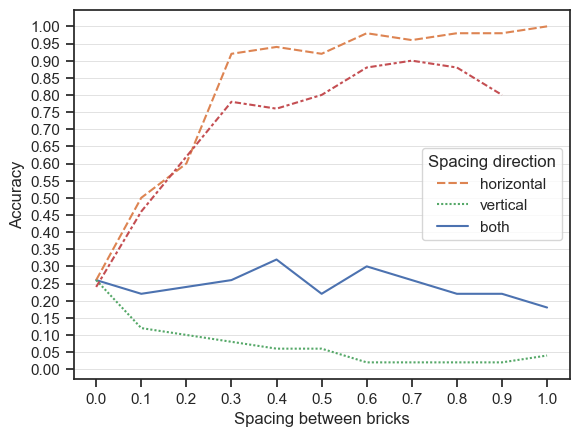

In [706]:

import seaborn as sns
# sns.set(style='ticks')

g = sns.lineplot(
    data=df,
    x='gap',
    y='correct',
    hue='gap_type',
    style='gap_type',
    # dashes=True
    )
# g.set_xticks(df['gap'])
g.set_yticks(np.arange(0,1.05,0.05))
g.set_xticks(np.arange(0,1.1,0.1))
plt.xlabel('Spacing between bricks')
plt.ylabel('Accuracy')
# plt.legend(title='Spacing direction')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Spacing direction')
plt.grid(axis='y', linewidth=0.4)


#### Ablation study 2 - Impact of assymetrical spacing

In [711]:
eval = []
individual_results_overall = []
results_dir = '../data/results/ablation_2'
# iterate over json files in the results directory
for file in os.listdir(results_dir):
    if file.endswith('.json'):
        results_file_path = os.path.join(results_dir, file)
        evaluation, individual_results = evaluate_results(results_filepath=results_file_path, individual_results=True, ablation=True)
        # add the model name to the evaluation
        evaluation['direction'] = file.strip('.json')
        eval.append(evaluation)
        individual_results_overall += individual_results
print(eval)

[{'accuracy': 0.712, 'precision': 0.8236026526964612, 'recall': 0.8854761904761906, 'direction': 'vs_times_4'}, {'accuracy': 0.402, 'precision': 0.6312912102517366, 'recall': 0.8162714285714288, 'direction': 'vs_times_2'}, {'accuracy': 0.434, 'precision': 0.6268719551947884, 'recall': 0.8000904761904769, 'direction': 'vs_plus_03'}]


In [712]:
df = pd.DataFrame(individual_results_overall)
df['correct'] = df['correct'].astype(int)
ablation_accuracy = df.groupby(['gap_type','gap'])['correct'].mean()

df = pd.DataFrame(ablation_accuracy)
df['gap'] = df.index.get_level_values(1)
df['gap_type'] = df.index.get_level_values(0)

df['gap'] = df['gap'].astype(float)
df['correct'] = df['correct'].astype(float)
df.sort_values(by=['gap_type','gap'], inplace=True)

ValueError: 'gap_type' is both an index level and a column label, which is ambiguous.

In [713]:
df

correct  gap    gap_type
gap_type   gap                          
vs_plus_03 0.0     0.88  0.0  vs_plus_03
           0.1     0.46  0.1  vs_plus_03
           0.2     0.42  0.2  vs_plus_03
           0.3     0.38  0.3  vs_plus_03
           0.4     0.38  0.4  vs_plus_03
           0.5     0.38  0.5  vs_plus_03
           0.6     0.38  0.6  vs_plus_03
           0.7     0.32  0.7  vs_plus_03
           0.8     0.38  0.8  vs_plus_03
           0.9     0.36  0.9  vs_plus_03
vs_times_2 0.0     0.26  0.0  vs_times_2
           0.1     0.32  0.1  vs_times_2
           0.2     0.40  0.2  vs_times_2
           0.3     0.38  0.3  vs_times_2
           0.4     0.38  0.4  vs_times_2
           0.5     0.40  0.5  vs_times_2
           0.6     0.44  0.6  vs_times_2
           0.7     0.46  0.7  vs_times_2
           0.8     0.52  0.8  vs_times_2
           0.9     0.46  0.9  vs_times_2
vs_times_4 0.0     0.24  0.0  vs_times_4
           0.1     0.46  0.1  vs_times_4
           0.2     0.62  0.2  vs_times_4
           0.3     0.78  0.3  vs_times_4
           0.4     0.76  0.4  vs_times_4
           0.5     0.80  0.5  vs_times_4
           0.6     0.88  0.6  vs_times_4
           0.7     0.90  0.7  vs_times_4
           0.8     0.88  0.8  vs_times_4
           0.9     0.80  0.9  vs_times_4

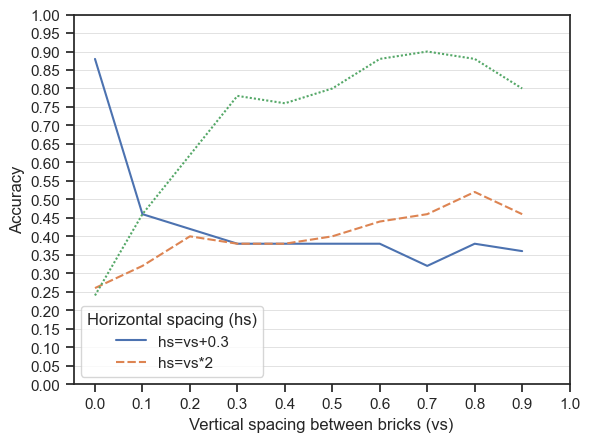

In [714]:

import seaborn as sns
# sns.set(style='ticks')

g = sns.lineplot(
    data=df,
    x='gap',
    y='correct',
    hue='gap_type',
    style='gap_type',
    # dashes=True
    )
# g.set_xticks(df['gap'])
g.set_yticks(np.arange(0,1.05,0.05))
g.set_xticks(np.arange(0,1.1,0.1))
plt.xlabel('Vertical spacing between bricks (vs)')
plt.ylabel('Accuracy')
# plt.legend(title='Spacing direction')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2]
labels = ['hs=vs+0.3', 'hs=vs*2', 'hs=vs*4']
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Horizontal spacing (hs)')
# plt.legend(title='Spacing direction', labels=['hs=vs+0.3', 'hs=vs*2'])
plt.grid(axis='y', linewidth=0.4)


In [715]:
df

correct  gap    gap_type
gap_type   gap                          
vs_plus_03 0.0     0.88  0.0  vs_plus_03
           0.1     0.46  0.1  vs_plus_03
           0.2     0.42  0.2  vs_plus_03
           0.3     0.38  0.3  vs_plus_03
           0.4     0.38  0.4  vs_plus_03
           0.5     0.38  0.5  vs_plus_03
           0.6     0.38  0.6  vs_plus_03
           0.7     0.32  0.7  vs_plus_03
           0.8     0.38  0.8  vs_plus_03
           0.9     0.36  0.9  vs_plus_03
vs_times_2 0.0     0.26  0.0  vs_times_2
           0.1     0.32  0.1  vs_times_2
           0.2     0.40  0.2  vs_times_2
           0.3     0.38  0.3  vs_times_2
           0.4     0.38  0.4  vs_times_2
           0.5     0.40  0.5  vs_times_2
           0.6     0.44  0.6  vs_times_2
           0.7     0.46  0.7  vs_times_2
           0.8     0.52  0.8  vs_times_2
           0.9     0.46  0.9  vs_times_2
vs_times_4 0.0     0.24  0.0  vs_times_4
           0.1     0.46  0.1  vs_times_4
           0.2     0.62  0.2  vs_times_4
           0.3     0.78  0.3  vs_times_4
           0.4     0.76  0.4  vs_times_4
           0.5     0.80  0.5  vs_times_4
           0.6     0.88  0.6  vs_times_4
           0.7     0.90  0.7  vs_times_4
           0.8     0.88  0.8  vs_times_4
           0.9     0.80  0.9  vs_times_4

In [710]:
# number of bricks per case


import numpy as np

# Recreating bricks for gap ablation study
dim = 2
N = 50
res_dir = f'../data/brick_{dim}D_50/'
open_path = os.path.join(res_dir, 'data.json')

brick_counts = []

with open(open_path, 'r') as f:
    data = json.load(f)
    for i, row in enumerate(data):
        brick_counts.append(sum([len(x.split(',')) for x in row['brick_layout']]))

In [683]:
brick_counts

[6,
 13,
 12,
 9,
 19,
 19,
 14,
 5,
 14,
 12,
 8,
 17,
 10,
 16,
 10,
 6,
 14,
 20,
 21,
 7,
 13,
 17,
 15,
 5,
 17,
 19,
 12,
 13,
 15,
 14,
 20,
 10,
 9,
 17,
 9,
 8,
 13,
 5,
 14,
 21,
 6,
 7,
 20,
 7,
 16,
 15,
 8,
 16,
 20,
 15]

In [685]:
for row in individual_results_overall:
    print(row['i'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27